In [1]:
import pickle 
import os
from datetime import datetime,timezone,timedelta
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from scipy import signal

import lib_data_filter as dafi
from lib_data_process import libDataProcess as dapr

In [2]:
azimut_mask = [270,330]
elevation_mask = [3,30]
min_height = 2
max_height = 4
t_range = 30
main_path_2 = os.path.abspath('../data/20221031/2/')
main_path_3 = os.path.abspath('../data/20221031/3/')

main_path = main_path_2
month = 10
day = 31

In [3]:
dapr_case = dapr()
frequency = dapr_case.generate_frequency(min_height=min_height,max_height=max_height)
signal_ts = {}

dt = 0
starttime = datetime(year=2022,month=month,day=day,hour=8,\
    minute=0+dt,second=0,tzinfo=timezone.utc)
endtime = datetime(year=2022,month=month,day=day,hour=14,\
    minute=0+dt,second=0,tzinfo=timezone.utc)
deltatime = timedelta(minutes=t_range)

data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,\
                    elevation_mask=elevation_mask,trigger='snr1')
split_data_dict = dafi.split_data(data_dict,starttime,endtime,\
                                    deltatime,sample_rate=1)


In [4]:
elevation = np.array([split_data_dict['G11']['raw'][0]['elevation']]).T
snr1 = np.array([split_data_dict['G11']['raw'][0]['snr1']]).T

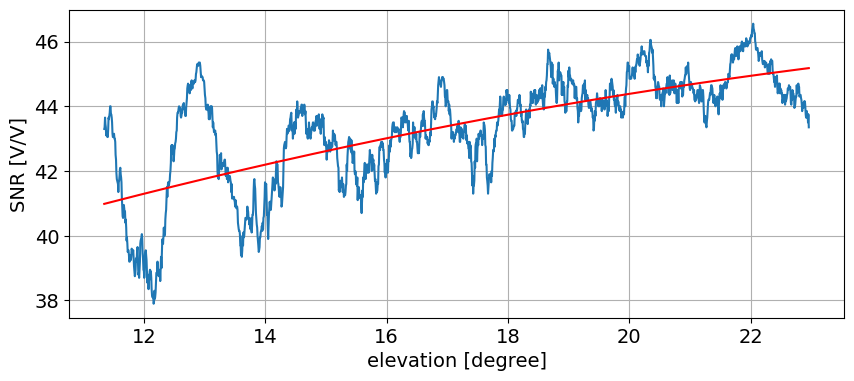

In [5]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots()
fig.set_size_inches(10,4)
design_matrix = np.concatenate((elevation**2,elevation,\
                    np.ones((elevation.size,1))),axis=1)
para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                design_matrix.T),snr1)
snr_ref = snr1 - (elevation**2 * para[0,0] + \
                para[1,0]*elevation + para[2,0])
ax.plot(elevation, snr1)
ax.plot(elevation,(elevation**2 * para[0,0] + \
                para[1,0]*elevation + para[2,0]),c='red')
ax.set_xlabel('elevation [degree]')
ax.set_ylabel('SNR [V/V]')
ax.grid()
fig.savefig(f'../../write/bilder/kapitel1/snrtrend.png',bbox_inches='tight')

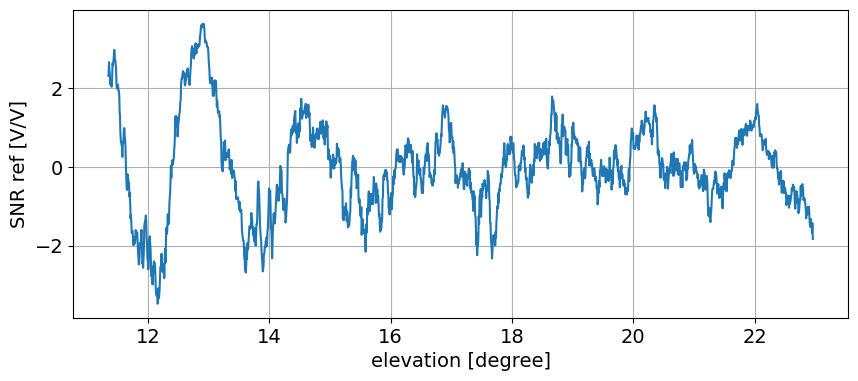

In [6]:
fig,ax = plt.subplots()
fig.set_size_inches(10,4)
ax.plot(elevation, snr_ref)
ax.set_xlabel('elevation [degree]')
ax.set_ylabel('SNR ref [V/V]')
ax.grid()
fig.savefig(f'../../write/bilder/kapitel1/snrresiduel.png',bbox_inches='tight')

In [17]:
C = 299792458 # m/s
FREQUENCY_GPS_L1 = 1575.42 * 10**6
np.arange(2,4,0.001)
wavelength = C/FREQUENCY_GPS_L1
x_data = (np.sin(elevation.T * np.pi/180) * 4 * np.pi / wavelength).ravel()
y_data = snr_ref.ravel()
power = signal.lombscargle(x_data,y_data,frequency,normalize=True)

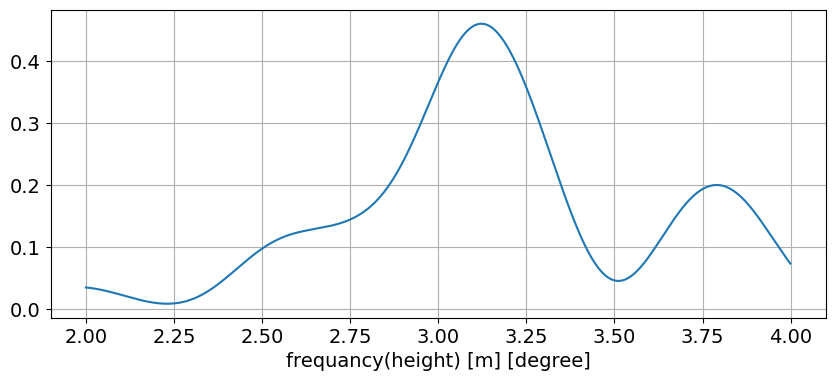

In [19]:
fig,ax = plt.subplots()
fig.set_size_inches(10,4)
ax.plot(frequency, power)
ax.set_xlabel('frequancy(height) [m] [degree]')
ax.grid()
#fig.savefig(f'../../write/bilder/kapitel1/example111.png',bbox_inches='tight')

In [7]:
import lib_import_other_datasource as imoda
date_key = '0811'
ts_gauge_0811 = imoda.get_gauge_data(date_key)
date_key = '0907'
ts_gauge_0907 = imoda.get_gauge_data(date_key)
date_key = '1004'
ts_gauge_1004 = imoda.get_gauge_data(date_key)
date_key = '1031'
ts_gauge_1031 = imoda.get_gauge_data(date_key)

ts_gauge = [np.mean(list(ts_gauge_0811.values())),
            np.mean(list(ts_gauge_0907.values())),
            np.mean(list(ts_gauge_1004.values())),
            np.mean(list(ts_gauge_1031.values()))]

In [8]:
ts_gauge

[284.48263636363635, 284.50718181818183, 284.499, 284.4926363636364]

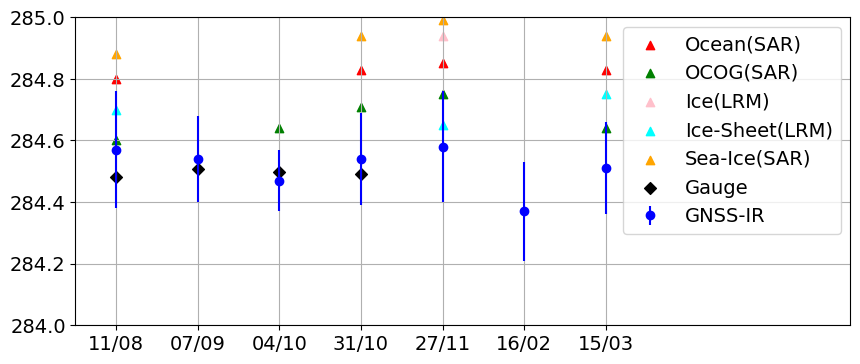

In [9]:


plt.rcParams.update({'font.size': 14})
date = ['11/08','07/09','04/10','31/10','27/11','16/02','15/03']
legend = ['Ocean(SAR)','OCOG(SAR)','Ice(LRM)','Ice-Sheet(LRM)','Sea-Ice(SAR)','Gauge','GNSS-IR']
xaxis = np.asarray([0,1,2,3,4,5,6])
gnss_ir = np.asarray([284.57,284.54,284.47,284.54,284.58,284.37,284.51])
std_gnss_ir = np.asarray([0.19,0.14,0.1,0.15,0.18,0.16,0.15])

oces = np.asarray([284.8,np.nan,np.nan,284.83,284.85,np.nan,284.83])
ogs = np.asarray([284.6,np.nan,284.64,284.71,284.75,np.nan,284.64])
iss = np.asarray([np.nan,np.nan,np.nan,np.nan,284.94,np.nan,np.nan])
icep = np.asarray([284.7,np.nan,np.nan,np.nan,284.65,np.nan,284.75])
sics = np.asarray([284.88,np.nan,np.nan,284.94,284.99,np.nan,284.94])
fig,ax = plt.subplots()

ax.scatter(xaxis,oces,marker='^',color='red')
ax.scatter(xaxis,ogs,marker='^',color='green')
ax.scatter(xaxis,iss,marker='^',color='pink')
ax.scatter(xaxis,icep,marker='^',color='cyan')
ax.scatter(xaxis,sics,marker='^',color='orange')
ax.errorbar(xaxis,gnss_ir,yerr=std_gnss_ir,fmt='o',color='blue')
ax.scatter(xaxis[0:4],ts_gauge,marker='D',color='black')
ax.grid()
ax.legend(legend,loc=1)
ax.set_xlim([-0.5,9])
ax.set_ylim([284,285])
ax.set_xticks(xaxis)
ax.set_xticklabels(date)
fig.set_size_inches(10,4)
fig.savefig(f'../../write/bilder/kapitel5/compare_retracker.png',bbox_inches='tight')